In [26]:
using Random
using Distributions
using LinearAlgebra
include("RSI-BBVI.jl")
include("../Inversion/Plot.jl")
include("../Derivative-Free-Variational-Inference/MultiModal.jl")
Random.seed!(110);

In [27]:
function PGM_visualization_2d(ax; Nx=200, Ny=200, x_lim=[-4.0,4.0], y_lim=[-4.0,4.0], func_Phi = nothing, objs=nothing, label=nothing)

    # visualization 
    x_min, x_max = x_lim
    y_min, y_max = y_lim

    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'   #'

    Z_ref = posterior_2d(func_Phi, X, Y, "func_Phi")
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

    N_obj = length(objs)
    N_iter = length(objs[1].logx_w) - 1
    error = zeros(N_obj, N_iter+1)
        
    for (iobj, obj) in enumerate(objs)
        N_modes = obj.N_modes
        for iter = 0:N_iter  
            x_w = exp.(obj.logx_w[iter+1]); x_w /= sum(x_w)
            x_mean = obj.x_mean[iter+1][:,1:2]
            xx_sqrt_cov = obj.xx_sqrt_cov[iter+1]
            cov_eps = obj.cov_eps[iter+1]
            xx_cov = zeros(N_modes,2,2)
            for im = 1:N_modes
                # y = xx_sqrt_cov[im, 1:2,:] 
                # xx_cov[im,:,:] = (I - y*inv(cov_eps[im]*I+xx_sqrt_cov[im,:,:]'*xx_sqrt_cov[im,:,:])*y')/cov_eps[im]
                xx_cov[im,:,:] = inv(cov_eps[im]*I + xx_sqrt_cov[im,:,:]*xx_sqrt_cov[im,:,:]')[1:2,1:2]
            end
            Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
            error[iobj, iter+1] = norm(Z - Z_ref,1)*dx*dy
            
            if iter == N_iter
                    
                ax[1+iobj].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                N_modes = size(x_mean, 1)
                ax[1+iobj].scatter([obj.x_mean[1][:,1];], [obj.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                ax[1+iobj].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
               
            end
        end
        
    end
    for i_obj = 1:N_obj
        ax[N_obj+2].semilogy(Array(0:N_iter), error[i_obj, :], 
                        label=(label===nothing ? label : label*" (K="*string(size(objs[i_obj].x_mean[1], 1))*")" ))   
   end
    # Get the current y-axis limits
    ymin, ymax = ax[N_obj+2].get_ylim()
    # Ensure the lower bound of y-ticks is below 0.1
    if ymin > 0.1
        ax[N_obj+2].set_ylim(0.1, ymax)  # Set the lower limit to a value below 0.1
    end
    if label!==nothing 
       ax[N_obj+2].legend()
    end
   
end

PGM_visualization_2d (generic function with 1 method)

dt = 0.000291074114405542

[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)


[ Info: ("iter = ", 150, " / ", 500)


dt = 0.0003910388256825168

[ Info: ("iter = ", 200, " / ", 500)



dt = 0.0002215309213401256


[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)


dt = 0.0001744284903222833


[ Info: ("iter = ", 400, " / ", 500)
[ Info: ("iter = ", 450, " / ", 500)


dt = 0.000324630284957633

[ Info: ("iter = ", 500, " / ", 500)


[ Info: ("iter = ", 50, " / ", 500)


dt = 0.00029143125582126384

[ Info: ("iter = ", 100, " / ", 500)


[ Info: ("iter = ", 150, " / ", 500)


dt = 0.0002604673021185339

[ Info: ("iter = ", 200, " / ", 500)


[ Info: ("iter = ", 250, " / ", 500)


dt = 0.0004485853169433187


[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)


dt = 0.000319201962857933


[ Info: ("iter = ", 400, " / ", 500)
[ Info: ("iter = ", 450, " / ", 500)


dt = 0.00021326243074591914


[ Info: ("iter = ", 500, " / ", 500)


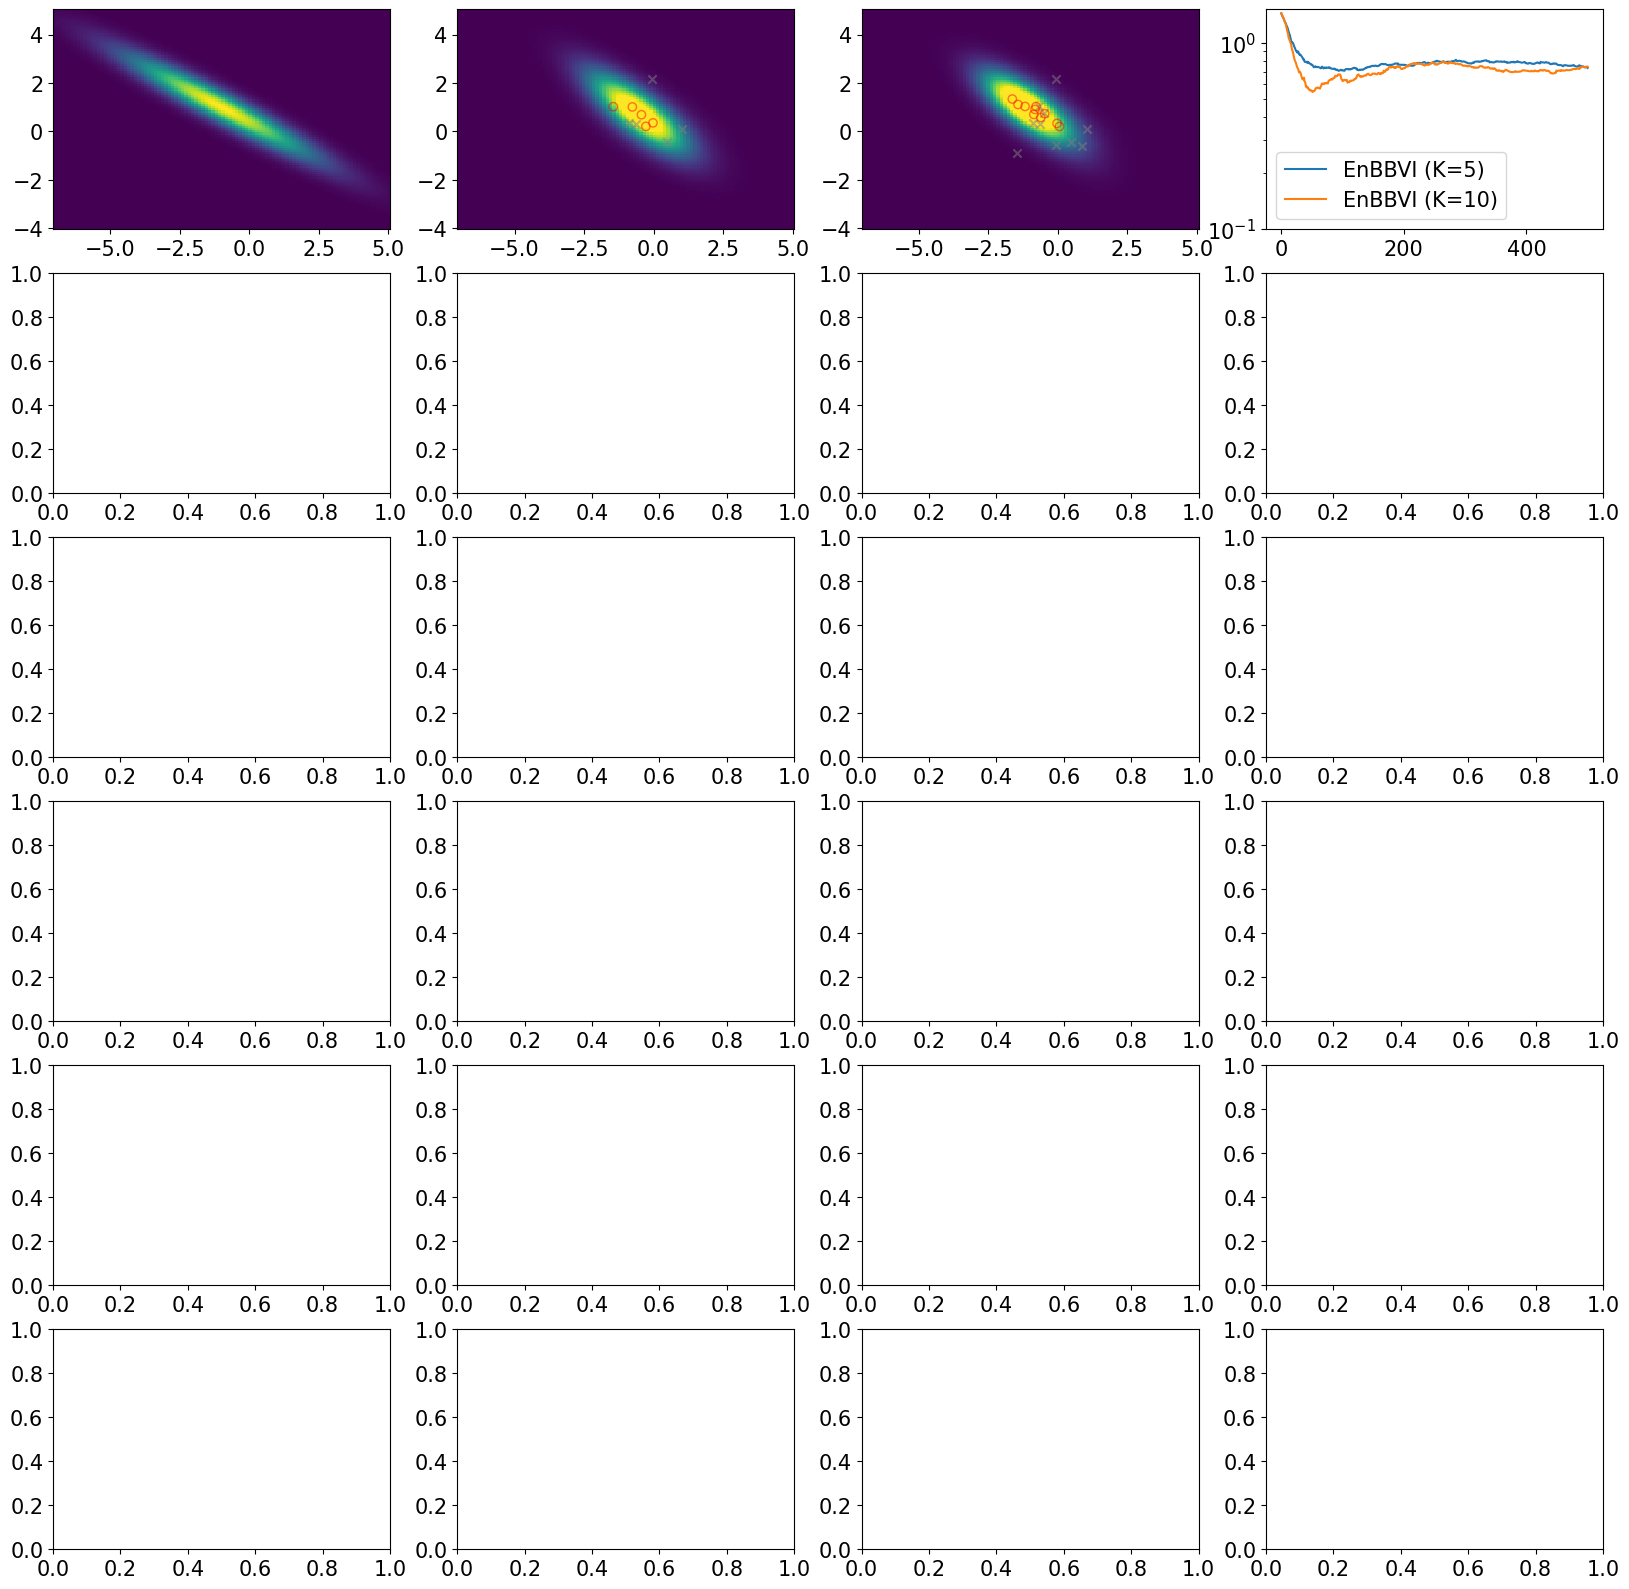

PyObject <matplotlib.legend.Legend object at 0x0000021286074D10>

In [28]:
N_modes_array = [5,10]
fig, ax = PyPlot.subplots(nrows=6, ncols=length(N_modes_array)+2, sharex=false, sharey=false, figsize=((length(N_modes_array)+2)*5,20))


N_modes = N_modes_array[end]
N_x = 20
N_r = 15
x0_w  = ones(N_modes)/N_modes
cov_eps0 = 0.1*ones(N_modes)  
μ0, Σ0 = zeros(N_x), Diagonal(ones(N_x))
x0_mean, xx0_sqrt_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_r)
for im = 1:N_modes
    x0_mean[im, :] .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    U, Σ, _ = svd(0.5*rand(N_x,N_r)/sqrt(N_r))
    xx0_sqrt_cov[im, :, :] = U.*(Σ')
end

N_iter = 500
Nx, Ny = 100,100

ση = 1.0
Gtype = "Gaussian"
dt = 0.2
A = [1.0 1.0; 1.0 2.0]
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_Phi(x) = 0.5*norm(func_F(x))^2
objs1 = [Gaussian_mixture_EnBBVI(func_Phi, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_sqrt_cov[1:N_modes,:,:], cov_eps0[1:N_modes]; N_iter = N_iter, dt = dt, random_quadrature_type = "single_Gaussian")
        for N_modes in N_modes_array]
y_2d = y[1:2]
func_args = (y_2d, ση, A , Gtype)
func_F(x) = F(x, func_args)
PGM_visualization_2d(ax[1,:]; Nx = Nx, Ny = Ny, x_lim=[-7.0, 5.0], y_lim=[-4.0, 5.0], func_Phi=func_Phi, objs=objs1, label="EnBBVI")



# ση = 1.0
# dt = 0.2
# Gtype = "Four_modes"
# y = [4.2297; 4.2297; 0.5; 0.0; zeros(N_x-2)]
# func_args = (y, ση, 0, Gtype)
# func_F(x) = F(x, func_args)
# func_Phi(x) = norm(func_F(x),2)^2/2
# objs = [Gaussian_mixture_EnBBVI(func_Phi, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_sqrt_cov[1:N_modes,:,:], cov_eps0[1:N_modes]; N_iter = N_iter, dt = dt)
#         for N_modes in N_modes_array]
# y_2d = y[1:4]
# func_args = (y_2d, ση, 0 , Gtype)
# func_F(x) = F(x, func_args) 
# PGM_visualization_2d(ax[2,:]; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-4.0, 4.0], func_Phi=func_Phi, objs=objs)


# ση = [sqrt(10.0);sqrt(10.0); ones(N_x-2)]
# Gtype = "Banana"
# dt = 0.1
# λ = 10.0
# y = [0.0; 1.0; zeros(N_x-2)]
# func_args = (y, ση, λ , Gtype)
# func_F(x) = F(x, func_args)
# func_Phi(x) = norm(func_F(x),2)^2/2
# μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
# objs1 = [Gaussian_mixture_EnBBVI(func_Phi, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_sqrt_cov[1:N_modes,:,:], cov_eps0[1:N_modes]; N_iter = N_iter, dt = dt)
#         for N_modes in N_modes_array]
# y_2d, ση_2d = y[1:2], ση[1:2]
# func_args = (y_2d, ση_2d, λ , Gtype)
# func_F(x) = F(x, func_args)
# PGM_visualization_2d(ax[3,:]; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 10.0], func_Phi=func_Phi, objs=objs1)




# fig.tight_layout()
# fig.savefig("BBVI-GMD-Multimodal.pdf")
